Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2024./2025.  
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Druga laboratorijska vježba: Linearni diskriminativni modeli i logistička regresija

*Verzija: 1.1 (ispravljena greška u tekstu prvog zadatka)  
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2025 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **3. studenog 2024. u 23:59h**

------------------------------

### Pravila predaje
Predajom vježbe potvrđujete sljedeće točke:
1. Niste od drugoga primili pomoć pri rješavanju vježbe;
2. Atribuirali ste dijelove koda koji su preuzeti s interneta referencirajući ih u komentarima;
3. Niste koristili dijelove koda s interneta koji su specifični za laboratorijsku vježbu;
4. Niste koristili UI-asistente za kodiranje kao npr. GitHub Copilot (uključivo alate generativne UI, kao što je ChatGPT).

**Povreda bilo kojeg od gornjih pravila smatra se prekršajem te povlači akademske sankcije.**

### Upute

Druga laboratorijska vježba sastoji se od šest zadataka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [681]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/ante/.local/lib/python3.10/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [682]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Linearna regresija kao klasifikator

U prethodnoj laboratorijskoj vježbi koristili smo model linearne regresije za, naravno, regresiju. Međutim, model linearne regresije može se koristiti i za **klasifikaciju**. Iako zvuči pomalo kontraintuitivno, zapravo je dosta jednostavno. Naime, cilj je naučiti funkciju $f(\mathbf{x})$ koja za pozitivne primjere predviđa vrijednost $1$, dok za negativne primjere predviđa vrijednost $0$. U tom slučaju, funkcija $f(\mathbf{x})=0.5$ predstavlja granicu između klasa, tj. primjeri za koje vrijedi $h(\mathbf{x})\geq 0.5$ klasificiraju se kao pozitivni, dok se ostali klasificiraju kao negativni.

Klasifikacija pomoću linearne regresije implementirana je u razredu [`RidgeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html). U sljedećim podzadatcima **istrenirajte** taj model na danim podatcima i **prikažite** dobivenu granicu između klasa. Pritom isključite regularizaciju ($\alpha = 0$, odnosno `alpha=0`). Također i ispišite **točnost** vašeg klasifikacijskog modela (smijete koristiti funkciju [`metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)). Skupove podataka vizualizirajte korištenjem pomoćne funkcije ``plot_clf_problem(X, y, h=None)`` koja je dana na početku ove bilježnice. `X` i `y` predstavljaju ulazne primjere i oznake, dok `h` predstavlja funkciju predikcije modela (npr. `model.predict`). 

U ovom zadatku cilj je razmotriti kako se klasifikacijski model linearne regresije ponaša na linearno odvojim i neodvojivim podatcima.

In [683]:
from sklearn.linear_model import LinearRegression, RidgeClassifier
from sklearn.metrics import accuracy_score

### (a)

Prvo, isprobajte *ugrađeni* model na linearno odvojivom skupu podataka `seven` ($N=7$).

In [684]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

[1 1 1 1 0 0 0]
Točnost: 1.0


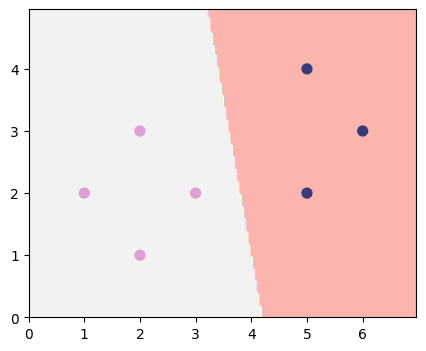

In [685]:
# Vaš kôd ovdje
plt.figure(figsize=(5,4))
classifier = RidgeClassifier(alpha=0)
model = classifier.fit(seven_X, seven_y)
predict = model.predict(seven_X)

print(predict)
print(f"Točnost: {accuracy_score(seven_y, predict)}")

plot_2d_clf_problem(seven_X, seven_y, model.predict)

Kako bi se uvjerili da se u isprobanoj implementaciji ne radi o ničemu doli o običnoj linearnoj regresiji, napišite kôd koji dolazi do jednakog rješenja korištenjem isključivo razreda [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Funkciju za predikciju, koju predajete kao treći argument `h` funkciji `plot_2d_clf_problem`, možete definirati lambda-izrazom: `lambda x : model.predict(x) >= 0.5`.

Točnost: 1.0


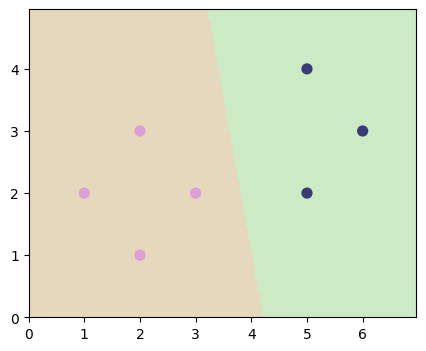

In [686]:
# Vaš kôd ovdje
classifier = LinearRegression()
model = classifier.fit(seven_X, seven_y)
predict = model.predict(seven_X)
predict = [int(round(x, 0)) for x in predict]
plt.figure(figsize=(5,4))


print(f"Točnost: {accuracy_score(seven_y, predict)}")
plot_2d_clf_problem(seven_X, seven_y, lambda x : model.predict(x) >= 0.5)

**Q:** Kako bi bila definirana granica između klasa ako bismo koristili oznake klasa $-1$ i $1$ umjesto $0$ i $1$?

### (b)  

Probajte isto na linearno odvojivom skupu podataka `outlier` ($N=8$):

In [687]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

Točnost: 0.875


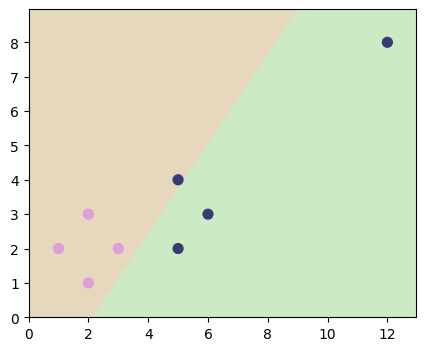

In [688]:
# Vaš kôd ovdje
classifier = LinearRegression()
model = classifier.fit(outlier_X, outlier_y)
predict = model.predict(outlier_X)
predict = [int(round(x, 0)) for x in predict]
plt.figure(figsize=(5,4))


print(f"Točnost: {accuracy_score(outlier_y, predict)}")
plot_2d_clf_problem(outlier_X, outlier_y, lambda x : model.predict(x) >= 0.5)

**Q:** Zašto model ne ostvaruje potpunu točnost iako su podatci linearno odvojivi?

### (c)  

Završno, probajte isto na linearno neodvojivom skupu podataka `unsep` ($N=8$):

In [689]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

Točnost: 0.875


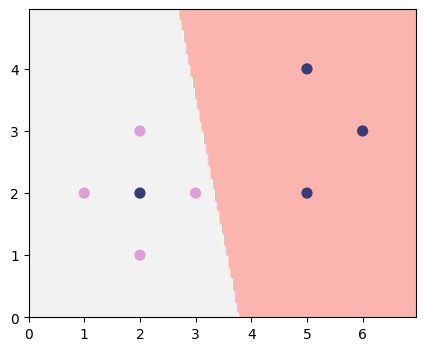

In [690]:
# Vaš kôd ovdje
classifier = RidgeClassifier()
model = classifier.fit(unsep_X, unsep_y)
predict = model.predict(unsep_X)
predict = [int(round(x, 0)) for x in predict]
plt.figure(figsize=(5,4))


print(f"Točnost: {accuracy_score(unsep_y, predict)}")
plot_2d_clf_problem(unsep_X, unsep_y, model.predict)

**Q:** Očito je zašto model nije u mogućnosti postići potpunu točnost na ovom skupu podataka. Međutim, smatrate li da je problem u modelu ili u podacima? Argumentirajte svoj stav.

### 2. Višeklasna klasifikacija

Postoji više načina kako se binarni klasifikatori mogu se upotrijebiti za višeklasnu klasifikaciju. Najčešće se koristi shema tzv. **jedan-naspram-ostali** (engl. *one-vs-rest*, OVR), u kojoj se trenira po jedan klasifikator $h_j$ za svaku od $K$ klasa. Svaki klasifikator $h_j$ trenira se da razdvaja primjere klase $j$ od primjera svih drugih klasa, a primjer se klasificira u klasu $j$ za koju je $h_j(\mathbf{x})$ maksimalan.

Pomoću funkcije [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) generirajte slučajan dvodimenzijski skup podataka od tri klase i prikažite ga koristeći funkciju `plot_2d_clf_problem`. Radi jednostavnosti, pretpostavite da nema redundantnih značajki te da je svaka od klasa "zbijena" upravo u jednu grupu.

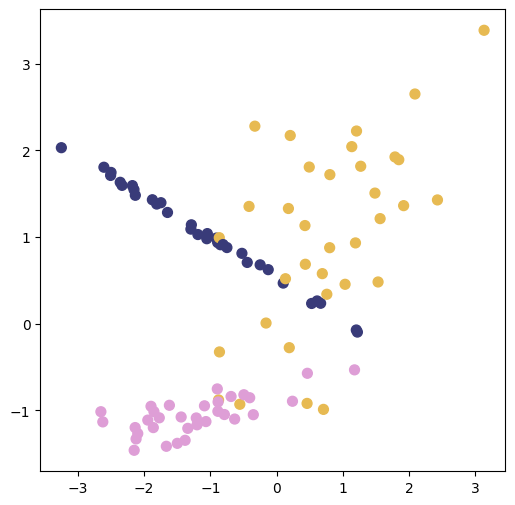

In [691]:
from sklearn.datasets import make_classification

# Vaš kôd ovdje
X, y = make_classification(n_features=2, n_classes=3, n_clusters_per_class=1, n_redundant=0)
plt.figure(figsize=(6,6))

plot_2d_clf_problem(X, y)


Trenirajte tri binarna klasifikatora, $h_1$, $h_2$ i $h_3$ te prikažite granice između klasa (tri grafikona). Zatim definirajte $h(\mathbf{x})=\mathrm{argmax}_j h_j(\mathbf{x})$  (napišite svoju funkciju `predict` koja to radi) i prikažite granice između klasa za taj model. Zatim se uvjerite da biste identičan rezultat dobili izravno primjenom modela `RidgeClassifier`, budući da taj model za višeklasan problem zapravo interno implementira shemu jedan-naspram-ostali.

**Q:** Alternativna shema jest ona zvana **jedan-naspram-jedan** (engl, *one-vs-one*, OVO). Koja je prednost sheme OVR nad shemom OVO? A obratno?

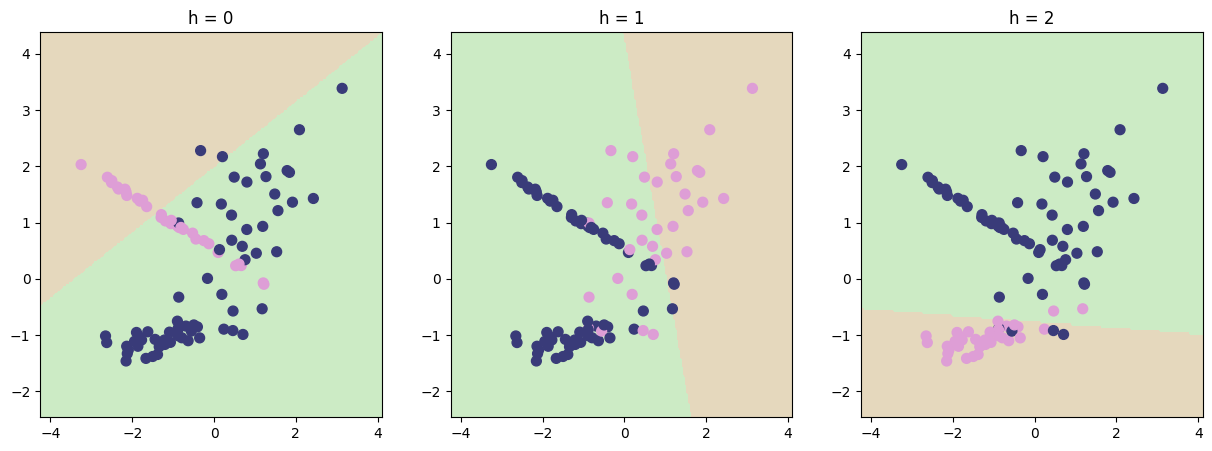

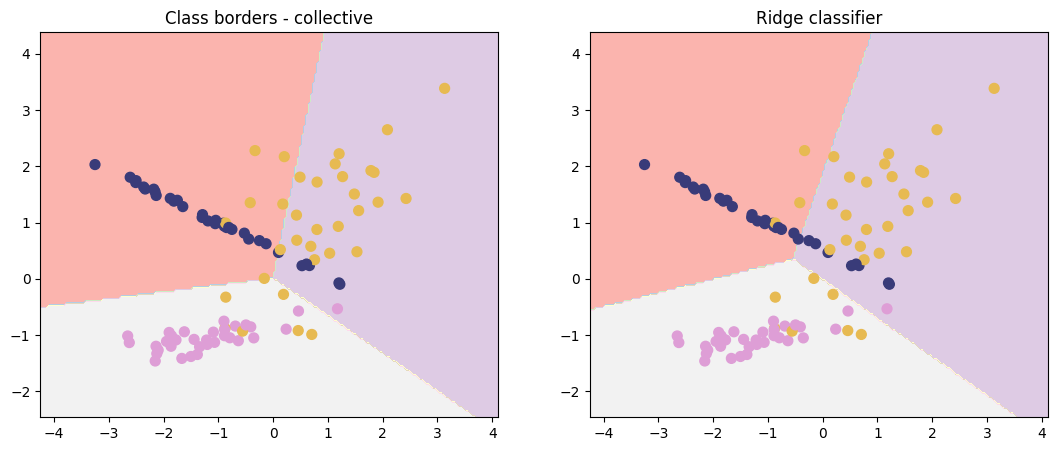

In [692]:
# Vaš kôd ovdje
clases_sep = [[1 if x == 0 else -1 for x in y], [1 if x == 1 else -1 for x in y], [1 if x == 2 else-1 for x in y]]
#clases_sep = [[1 if x == 0 else 0 for x in y], [1 if x == 1 else 0 for x in y], [1 if x == 2 else 0 for x in y]]


weights = [linalg.pinv(X) @ clases_sep[x] for x in range(3)]
# https://www.geeksforgeeks.org/matplotlib-pyplot-sca-in-python/
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for j in range(3):
    plt.sca(axs[j])
    plot_2d_clf_problem(X, clases_sep[j],lambda x: (x @ weights[j]) >= 0.5 )
    plt.title(f"h = {j}")
plt.show()

def predict(X_input):
    predicts = np.array( [X_input @ weights[x] for x in range(3)] )
    pred_new =[]
    for i in range(len(predicts[0])):
        case = [predicts[0][i], predicts[1][i], predicts[2][i]]
        if max(case) == predicts[0][i]:
            pred_new.append(0)
        elif max(case) == predicts[1][i]:
            pred_new.append(1)
        else:
            pred_new.append(2)
    return np.array(pred_new)
        
classifier = RidgeClassifier(alpha=0)
model = classifier.fit(X, y)

fig, axs = plt.subplots(1, 2, figsize=(13,5))
plt.sca(axs[0])
plot_2d_clf_problem(X, y, predict)
plt.title("Class borders - collective")
plt.sca(axs[1])
plt.title("Ridge classifier")
plot_2d_clf_problem(X, y, model.predict)




        

### 3. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

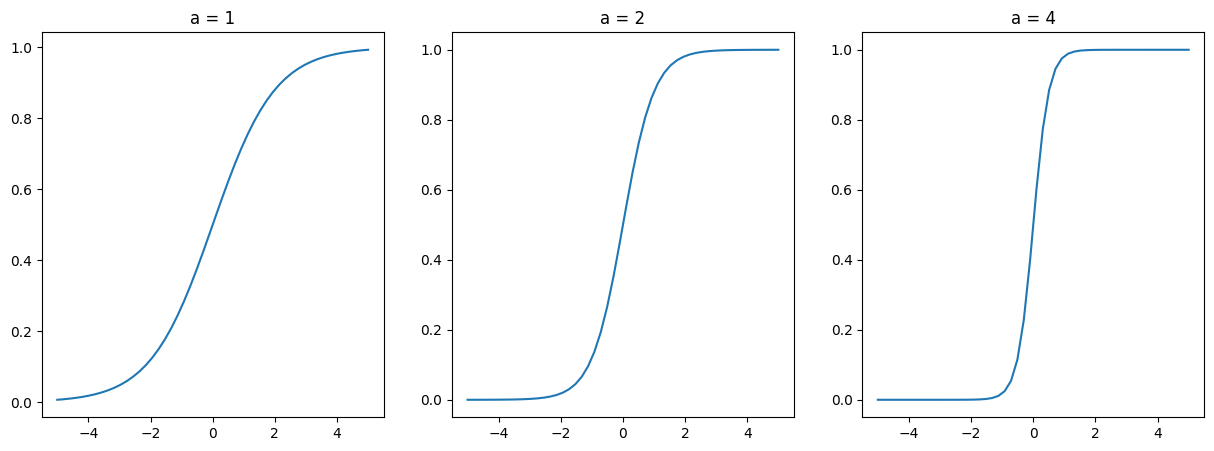

In [693]:
# Vaš kôd ovdje
x = np.linspace(-5, 5)

sigm = lambda x, a: 1/(1+pow(np.e, (-1) *a * x))

fig, ax = plt.subplots(1, 3, figsize=(15,5))

plt.sca(ax[0])
plt.plot(x, sigm(x, 1))
plt.title("a = 1")
plt.sca(ax[1])
plt.plot(x, sigm(x, 2))
plt.title("a = 2")
plt.sca(ax[2])
plt.plot(x, sigm(x, 4))
plt.title("a = 4")
plt.show()
# plt.figure(figsize = (5,4))
# plt.plot(x, sigm(0.2))
# plt.title("a = 0.2")
# plt.show()

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [694]:
from numpy import linalg
    
# Vaš kôd ovdje

lr_h = lambda x, w: sigm(x@w, 1)

def cross_entropy_error(X, y, w):
    err = 0
    preds = lr_h(X, w)
    for i in range(len(y)):
        err += (-y[i]) * log(preds[i]) - (1-y[i]) * log(1-preds[i])
    return err/len(y)
    
def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    N, n = X.shape
    w = np.zeros(n)
    history = []
    
    if trace:
        history = [w.copy()]
    
    prev_err = float("Inf")
    curr_err = 0
    i = 0
    while i < max_iter and abs(curr_err-prev_err) > epsilon:
        h = lr_h(X, w)
        deltaErr = ((h-y) @ X)
        
        w[0] -= deltaErr[0]*eta
        
        if alpha != 0:
            w[1:] = w[1:] * (1-eta*alpha)
        w[1:] = w[1:] - eta * deltaErr[1:]

        if trace:
            history.append(w.copy())
            
        prev_err = curr_err
        curr_err = cross_entropy_error(X,y,w)
        i += 1
        
    if trace:
        return w, history
    return w
            

### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [695]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

[ 4.45449454 -1.71089242  0.68413507]
Cross entropy err: 0.13521872720206746


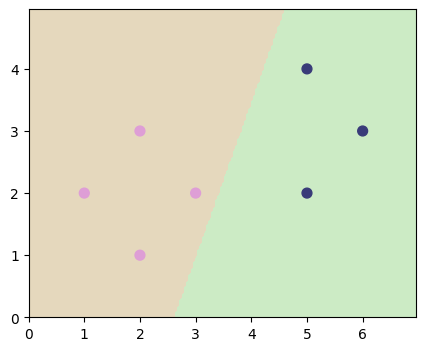

In [696]:
# Vaš kôd ovdje
X_new = np.append(np.ones((seven_X.shape[0],1)), seven_X, axis=1)

w = lr_train(X_new, seven_y)
print(w)

plt.figure(figsize=(5,4))
plot_2d_clf_problem(seven_X, seven_y, lambda x: lr_h(np.append(np.ones((x.shape[0],1)), x, axis=1), w) >= 0.5)
print(f"Cross entropy err: {cross_entropy_error(X_new, seven_y, w)}")

**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [697]:
from sklearn.metrics import zero_one_loss

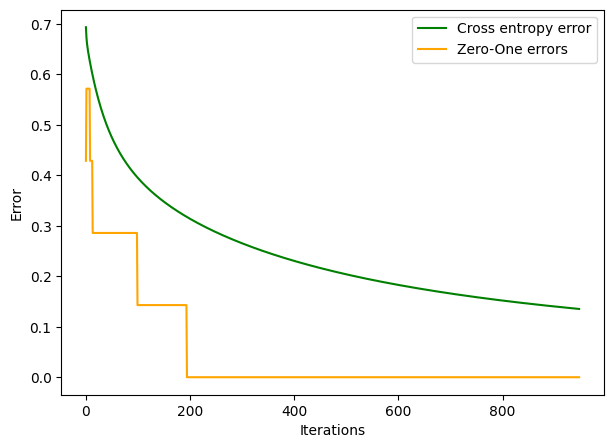

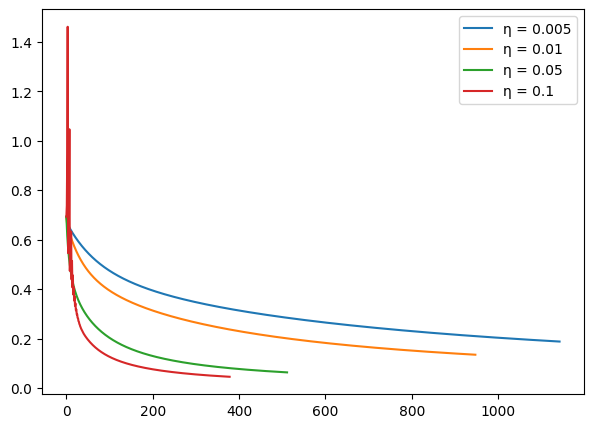

In [698]:
# Vaš kôd ovdje
w, history = lr_train(X_new, seven_y, trace=True)
cross_errors = [cross_entropy_error(X_new, seven_y, hist_w) for hist_w in history]
zero_one = [zero_one_loss(seven_y, lr_h(X_new, hist_w)>=0.5) for hist_w in history]
plt.figure(figsize=(7,5))
plt.plot(range(len(history)), cross_errors, c="green", label="Cross entropy error")
plt.plot(range(len(history)), zero_one, c="orange", label="Zero-One errors")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.legend()
plt.show()

eta = [0.005, 0.01, 0.05, 0.1]
plt.figure(figsize=(7,5))
for e in eta:
    w, history = lr_train(X_new, seven_y, eta=e, trace=True)
    cross_errors = [cross_entropy_error(X_new, seven_y, hist_w) for hist_w in history]
    # https://stackoverflow.com/questions/54827612/print-greek-letter-in-printed-string
    plt.plot(range(len(history)), cross_errors, label=f"\N{GREEK SMALL LETTER ETA} = {e}")

plt.legend()
plt.show()

    


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

In [699]:
from sklearn.linear_model import LogisticRegression

# Vaš kôd ovdje
lr = LogisticRegression().fit(X_new, seven_y)
print(lr.coef_[0])
print(f"Cross err: {cross_entropy_error(X_new, seven_y, lr.coef_[0])}")


[ 1.79054171e-05 -1.18243244e+00 -3.02449283e-01]
Cross err: 1.7366217327440978


### 4. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [700]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

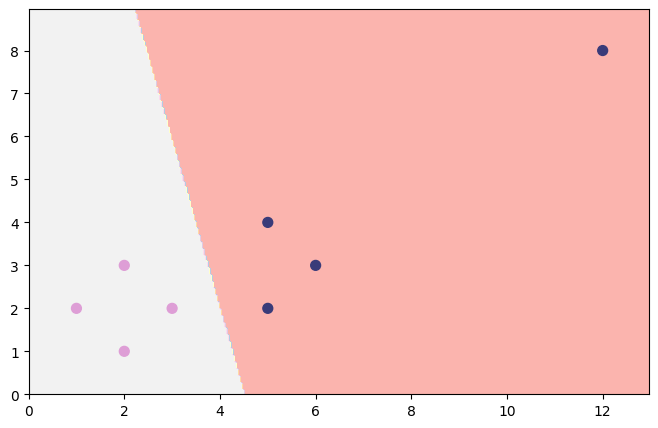

In [701]:
# Vaš kôd ovdje
figure(figsize=(8,5))
lr = LogisticRegression().fit(outlier_X, outlier_y)
plot_2d_clf_problem(outlier_X, outlier_y, lr.predict)

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

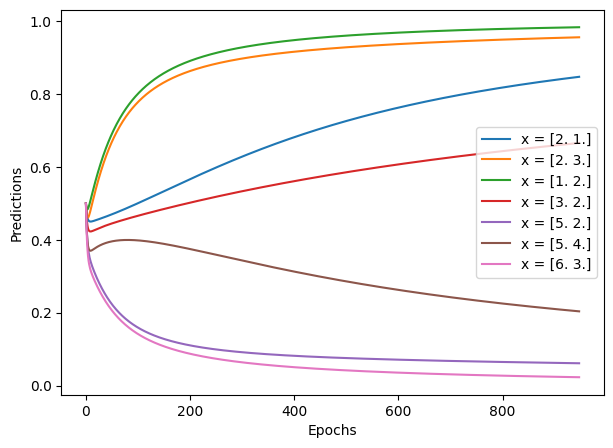

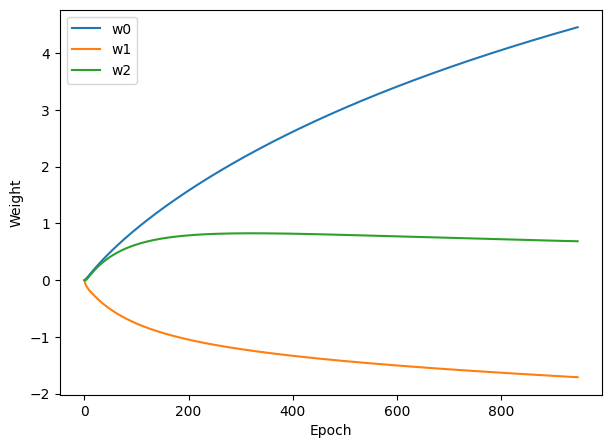

In [702]:
# Vaš kôd ovdje
w, history = lr_train(X_new, seven_y, trace=True)

figure(figsize=(7,5))
for i,x in enumerate(X_new):
    pred = [lr_h(x,w) for w in history]
    plt.plot(range(len(history)), pred, label=f"x = {x[1:]}")

plt.xlabel("Epochs")
plt.ylabel("Predictions")
plt.legend()
plt.show()
history = np.matrix(history)

figure(figsize=(7,5))
plt.plot(range(len(history)), history[:,0], label="w0")
plt.plot(range(len(history)), history[:,1], label="w1")
plt.plot(range(len(history)), history[:,2], label="w2")
plt.xlabel("Epoch")
plt.ylabel("Weight")
plt.legend()
plt.show()

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [703]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

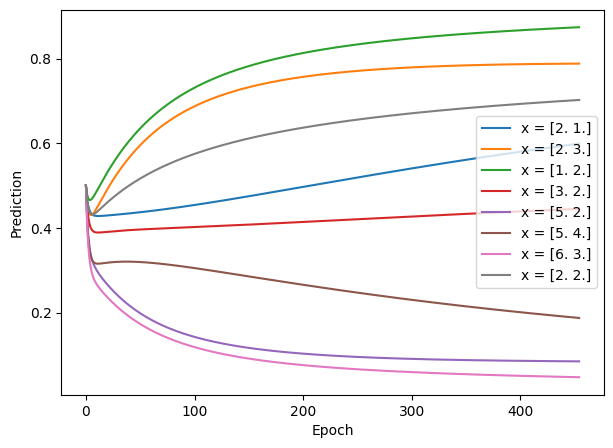

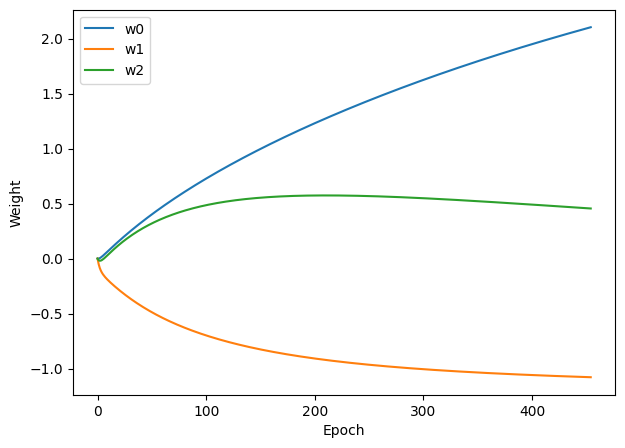

In [704]:
# Vaš kôd ovdje
X_new = np.append(np.ones((unsep_X.shape[0],1)), unsep_X, axis=1)
w, history = lr_train(X_new, unsep_y, trace=True)

figure(figsize=(7,5))
for i,x in enumerate(X_new):
    pred = [lr_h(x,w) for w in history]
    plt.plot(range(len(history)), pred, label=f"x = {x[1:]}")

plt.xlabel("Epoch")
plt.ylabel("Prediction")
plt.legend()
plt.show()
history = np.matrix(history)

figure(figsize=(7,5))
plt.plot(range(len(history)), history[:,0], label="w0")
plt.plot(range(len(history)), history[:,1], label="w1")
plt.plot(range(len(history)), history[:,2], label="w2")
plt.xlabel("Epoch")
plt.ylabel("Weight")
plt.legend()
plt.show()

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 5. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [705]:
from numpy.linalg import norm

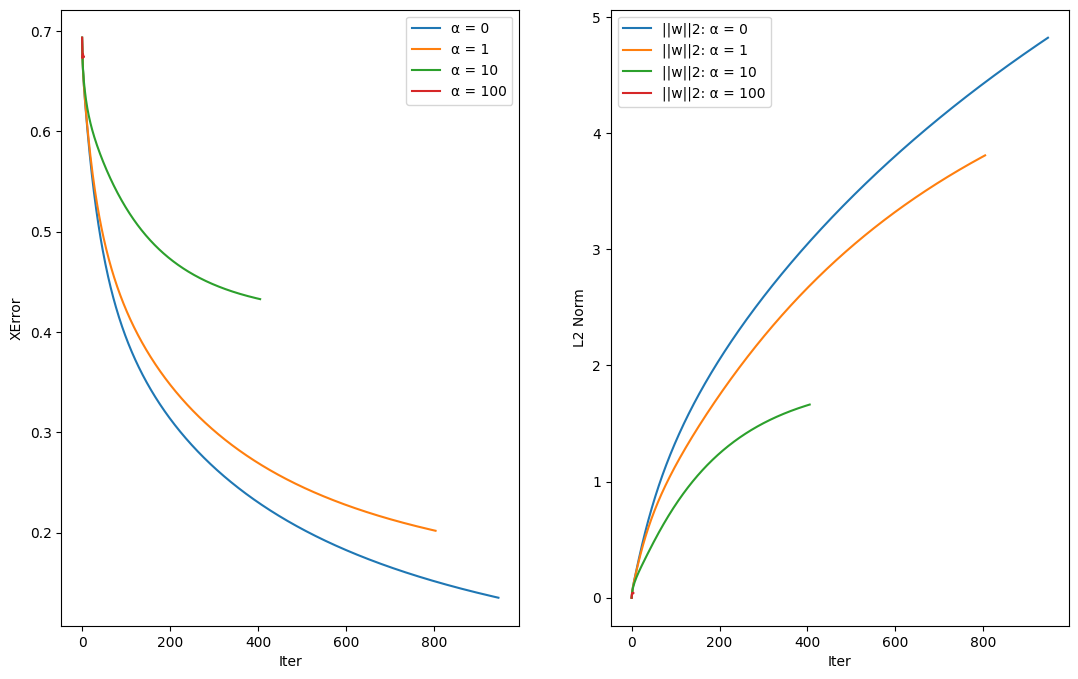

In [706]:
# Vaš kôd ovdje
X_new = np.append(np.ones((seven_X.shape[0],1)), seven_X, axis=1)

factors = [0, 1, 10, 100]
plt.figure(figsize=(13,8))
for a in factors:
    w, history = lr_train(X_new, seven_y, alpha=a, trace=True)
    errs = [cross_entropy_error(X_new, seven_y, wh) for wh in history]
    l2Reg = [sqrt(sum(wh**2)) for wh in history]
    plt.subplot(1,2,1)
    plt.plot(range(len(history)), errs, label=f"\N{GREEK SMALL LETTER ALPHA} = {a}")
    plt.xlabel("Iter")
    plt.ylabel("XError")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(range(len(history)), l2Reg, label=f"||w||2: \N{GREEK SMALL LETTER ALPHA} = {a}")
    plt.xlabel("Iter")
    plt.ylabel("L2 Norm")
    plt.legend()
plt.show()
    


**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 6. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

In [707]:
from sklearn.preprocessing import PolynomialFeatures

#plot_2d_clf_problem(X, y, lambda x : model.predict(poly.transform(x))

/home/ante/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


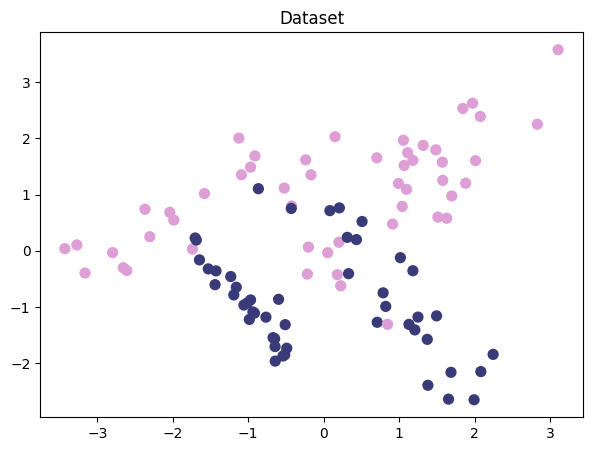

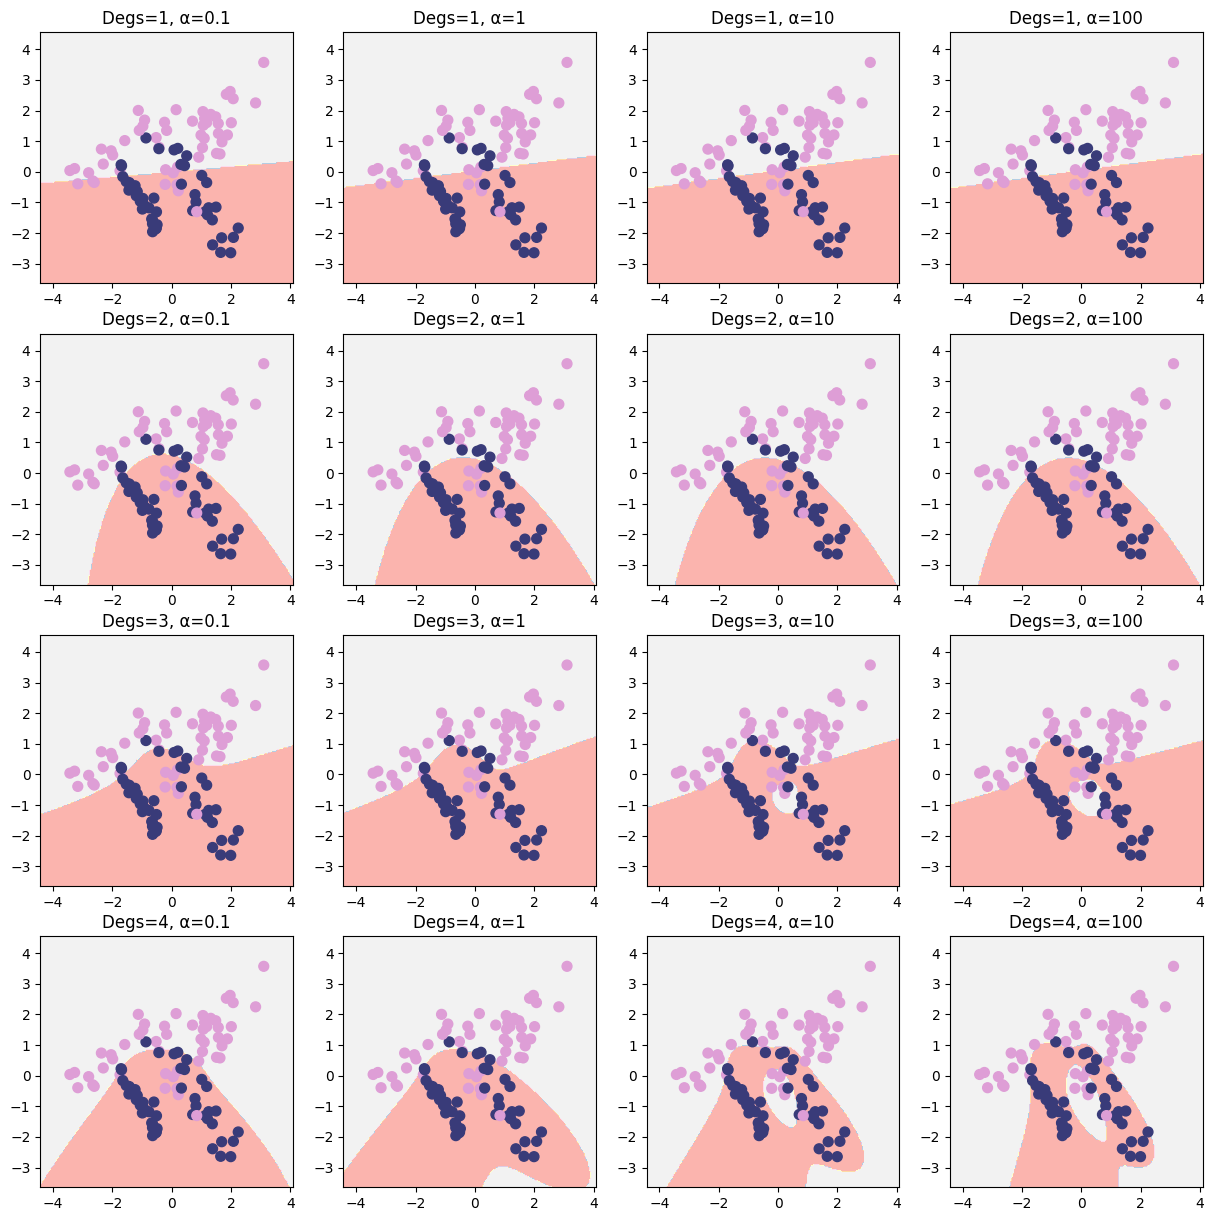

In [708]:
from sklearn.datasets import make_classification

# Vaš kôd ovdje
X, y = make_classification(100, 2, n_informative=2, n_redundant=0, n_classes=2, n_clusters_per_class=2)
# x2D = PolynomialFeatures(2).fit_transform(X)
# x3D = PolynomialFeatures(3).fit_transform(X)

# model2D = LogisticRegression().fit(x2D, y)
# model3D = LogisticRegression().fit(x3D, y)

# plot_2d_clf_problem(X, y, lambda x: model2D.predict(PolynomialFeatures(2).fit_transform(x)))
# plot_2d_clf_problem(X, y, lambda x: model3D.predict(PolynomialFeatures(3).fit_transform(x)))

figure(figsize=(7,5))
plt.title("Dataset")
plot_2d_clf_problem(X, y)

figure(figsize=(15,15))
degs = [1,2,3,4]
factors = [0.1, 1, 10, 100]

for i, d in enumerate(degs):
    for j, alpha in enumerate(factors):
        fi = PolynomialFeatures(d).fit_transform(X)
        model = LogisticRegression(C=alpha).fit(fi, y)
        plt.subplot(len(degs), len(factors), i*len(factors) + j + 1)
        plt.title(f"Degs={d}, \N{GREEK SMALL LETTER ALPHA}={alpha}")
        plot_2d_clf_problem(X, y, lambda x: model.predict(PolynomialFeatures(d).fit_transform(x)))
        
        
        

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?